In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("../data/raw/numerical.csv")

In [3]:
df.head()

,date,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,...,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,percentAumCovered,sustainRank,responsible,sustainScore
0,2024-12-31,0.0,0.237,1.690800e+09,NaN,NaN,1.150600e+09,175400000.0,4.144100e+09,1.690800e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,2023-12-31,0.0,0.241,1.710100e+09,NaN,NaN,1.155000e+09,177300000.0,3.992200e+09,1.710100e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,2022-12-31,0.0,0.245,1.630900e+09,NaN,NaN,1.086900e+09,176600000.0,3.764800e+09,1.630900e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,2021-12-31,0.0,0.234,1.388200e+09,NaN,NaN,9.250000e+08,170700000.0,3.233700e+09,1.388200e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,2020-12-31,NaN,NaN,NaN,1400000.0,1400000.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [4]:
front_columns = ['symbol', 'date', 'companySize', 'region', 'totalEsg', 'shortName', 'longName', 'marketCap', 'cumulativeMarketCapPercentage']

all_columns = df.columns.tolist()
new_column_order = front_columns + [col for col in all_columns if col not in front_columns] 

# Reindex the DataFrame with the new column order
df = df[new_column_order]


In [5]:
df.head()

,symbol,date,companySize,region,totalEsg,shortName,longName,marketCap,cumulativeMarketCapPercentage,Tax Effect Of Unusual Items,...,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,percentAumCovered,sustainRank,responsible,sustainScore
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [6]:
df.shape

(4646, 392)

In [7]:
df['symbol'].nunique()

1012

In [8]:
# Create a latest_date feature to align different EOY financial dates
df['latest_date'] = df.groupby('symbol')['date'].transform('max')

In [9]:
df['latest_date'].value_counts()

latest_date
2024-12-31    2603
2024-03-31     925
2023-12-31     444
2024-06-30     180
2024-09-30     156
2025-01-31      74
2024-02-29      58
2024-08-31      44
2024-07-31      34
2024-10-31      33
2024-01-31      28
2024-05-31      25
2024-04-30      15
2023-03-31      11
2022-12-31      11
2024-11-30       5
Name: count, dtype: int64

In [10]:
df['latest_year'] = df['latest_date'].apply(lambda x: x.split('-')[0])

## Data Cleaning

### Assessing Missingness Patterns

In [11]:
df.shape

(4646, 394)

In [12]:
# Drop features with more than 70% missing values, as they offer too little information to be imputed
pct_null = df.isnull().mean()
df = df.drop(columns=pct_null[pct_null > 0.7].index.tolist())
df.shape

(4646, 233)

### Assessing constant features

Features with zero or very low variance provide little information and can be removed.

In [13]:
# Calculate variance for each numerical column
feature_variance = df.var(numeric_only=True)
feature_variance.sort_values(ascending=True).head(10)

maxAge                             0.000000
Tax Rate For Calcs                 0.006051
ratingYear                         0.513186
highestControversy                 1.181631
ratingMonth                        4.228918
governanceScore                    8.557575
socialScore                       12.425297
environmentScore                  33.442564
totalEsg                          69.034408
cumulativeMarketCapPercentage    368.737453
dtype: float64

In [14]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(df.select_dtypes(include=[np.number]).fillna(0))
constant_feats = df.select_dtypes(include=[np.number]).columns[~vt.get_support()]
constant_feats

Index(['Tax Rate For Calcs', 'maxAge'], dtype='object')

In [15]:
df = df.drop(columns=constant_feats)

In [16]:
df.shape

(4646, 231)

### Missing Value Imputation

Step 1: Company‑level ffill/bfill (and/or rolling)

Step 2: Peer‑group imputation (region + company size + year)

Step 3: Global/statistical imputer (median) for any stragglers

In [17]:
# defining columns that should be imputed
df_sorted = df.sort_values(by=['symbol', 'latest_year'], ascending=True)
meta_numeric = ['date', 'latest_date', 'latest_year', 'totalEsg', 'environmentScore', 'socialScore', 'governanceScore']

cols_to_impute = df_sorted.select_dtypes(include=np.number).columns.tolist()
# remove identifiers/targets if they are numeric and shouldn't be imputed this way
cols_to_impute = [col for col in cols_to_impute if col not in meta_numeric]

In [18]:
# Step 1: company-level historical imputation
df_filled = df_sorted.copy()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].ffill()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].bfill()

In [19]:
len(df_filled[cols_to_impute].columns[df_filled[cols_to_impute].isnull().any()].tolist())

161

In [20]:
# Step 2
cols_to_impute_final = [
    col for col in df_filled.select_dtypes(include=np.number).columns.tolist()
    if col not in meta_numeric
    and df_filled[col].isnull().any() # Only consider columns with NaNs remaining
]

In [21]:
df_filled.groupby(['region', 'companySize', 'latest_year']).count().head()

symbol  date  totalEsg  \
region              companySize latest_year                           
east_asia_n_pacific Large-Cap   2022              3     3         3   
                                2023             48    48        48   
                                2024            204   204       204   
                    Mid-Cap     2023            104   104       104   
                                2024            332   332       332   

                                             shortName  longName  marketCap  \
region              companySize latest_year                                   
east_asia_n_pacific Large-Cap   2022                 3         3          3   
                                2023                48        48         48   
                                2024               204       204        204   
                    Mid-Cap     2023               104       104        104   
                                2024               332       332        332   

                                             cumulativeMarketCapPercentage  \
region              companySize latest_year                                  
east_asia_n_pacific Large-Cap   2022                                     3   
                                2023                                    48   
                                2024                                   204   
                    Mid-Cap     2023                                   104   
                                2024                                   332   

                                             Tax Effect Of Unusual Items  \
region              companySize latest_year                                
east_asia_n_pacific Large-Cap   2022                                   3   
                                2023                                  48   
                                2024                                 204   
                    Mid-Cap     2023                                 104   
                                2024                                 332   

                                             Normalized EBITDA  \
region              companySize latest_year                      
east_asia_n_pacific Large-Cap   2022                         3   
                                2023                        40   
                                2024                       158   
                    Mid-Cap     2023                        84   
                                2024                       273   

                                             Total Unusual Items  ...  \
region              companySize latest_year                       ...   
east_asia_n_pacific Large-Cap   2022                           3  ...   
                                2023                          44  ...   
                                2024                         189  ...   
                    Mid-Cap     2023                          92  ...   
                                2024                         252  ...   

                                             furLeather  gambling  gmo  \
region              companySize latest_year                              
east_asia_n_pacific Large-Cap   2022                  3         3    3   
                                2023                 48        48   48   
                                2024                204       204  204   
                    Mid-Cap     2023                104       104  104   
                                2024                332       332  332   

                                             militaryContract  nuclear  \
region              companySize latest_year                              
east_asia_n_pacific Large-Cap   2022                        3        3   
                                2023                       48       48   
                                2024                      204      204   
                    Mid-Cap     2023             

In [22]:
for col in cols_to_impute_final:
    # Use transform with median. It aligns results back to the original DataFrame index.
    df_filled[col] = df_filled.groupby(['region', 'companySize', 'latest_year'])[col].transform(lambda x: x.fillna(x.median()))

In [ ]:
remaining_nan_counts = df_filled[cols_to_impute_final].isnull().sum()
cols_still_nan = remaining_nan_counts[remaining_nan_counts > 0].index.tolist()

In [24]:
remaining_nan_counts[remaining_nan_counts > 0].sort_values(ascending=True).head(10)

Other Properties                        2
Net Business Purchase And Sale          2
Net Investment Purchase And Sale        2
Goodwill And Other Intangible Assets    3
Operating Cash Flow                     3
Other Non Cash Items                    3
Change In Payable                       3
Change In Working Capital               3
Depreciation And Amortization           3
Other Intangible Assets                 3
dtype: int64

In [28]:
len(remaining_nan_counts[remaining_nan_counts > 20].index.tolist())

64

In [29]:
# Step 3
for col in cols_still_nan:
    global_median_val = df_filled[col].median()
    df_filled[col] = df_filled[col].fillna(global_median_val)

    df_filled[cols_to_impute_final].isnull().sum().sort_values(ascending=True).head(10)

In [31]:
df_filled.sort_index().head()

,symbol,date,companySize,region,totalEsg,shortName,longName,marketCap,cumulativeMarketCapPercentage,Tax Effect Of Unusual Items,...,gambling,gmo,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,latest_date,latest_year
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024


In [32]:
df = df_filled

In [33]:
df.columns[df.isnull().any()].tolist()

['shortName',
 'longName',
 'environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco']

## Feature Engineering

### Feature Creation

Creating different financial ratios

In [ ]:
def safe_div(numer, denom):
    """Divide two values, returning NaN where denominator is zero or NaN."""
    return numer.div(denom).replace([np.inf, -np.inf], np.nan)

# Defining the ratios to be calculated and their required features
financial_ratios = {
    'profit_margin': (['Net Income'], 'Operating Revenue'),
    'ROA': (['Net Income'], 'Total Assets'),
    'ROE': (['Net Income Common Stockholders'], 'Common Stock Equity'),
    'debt_to_equity': (['Total Debt'], 'Total Equity Gross Minority Interest'),
    'interest_coverage': (['EBIT'], 'Interest Expense'),
    'current_ratio': (['Current Assets'], 'Current Liabilities'),
    'quick_ratio': (['Current Assets', 'Inventory'], 'Current Liabilities'),
    # below are ratios suggested by D'amato et al. (2021)
    'sales_to_assets': [['Total Revenue'], 'Total Assets'],
    'EBIT_to_sales': [['EBIT'], 'Total Revenue'],
    'dividend_yield': [['Cash Dividends Paid'], 'marketCap'],
    'net_income_to_sales': [['Net Income'], 'Total Revenue'],
    'liquidity_ratio': [['Current Assets'], 'Current Liabilities'],
    'solvency_ratio': [['Total Debt'], 'Total Assets'],
    'price_to_earnings': [['marketCap', 'Ordinary Shares Number'], 'Diluted EPS'],
}

In [35]:
# Handle the creation of financial ratios
for name, (num_cols, den_col) in financial_ratios.items():
    if den_col in df.columns and all(c in df.columns for c in num_cols):
        print(f"Calculating {name}...")
        # handles the cases where the numerator is a list of columns
        if len(num_cols) > 1:
            if name == 'price_to_earnings':
                numerator = safe_div(df[num_cols[0]], df[num_cols[1]])
            elif name == 'quick_ratio':
                numerator = df[num_cols[0]] - df[num_cols[1]]
            else:
                print("Undefined numerator for this ratio")
                continue
        else:   
            numerator = df[num_cols].sum(axis=1)
        df[name] = safe_div(numerator, df[den_col])

Calculating profit_margin...
Calculating ROA...
Calculating ROE...
Calculating debt_to_equity...
Calculating interest_coverage...
Calculating current_ratio...
Calculating quick_ratio...
Calculating sales_to_assets...
Calculating EBIT_to_sales...
Calculating dividend_yield...
Calculating net_income_to_sales...
Calculating liquidity_ratio...
Calculating solvency_ratio...
Calculating price_to_earnings...


C:\Users\Mishaal\AppData\Local\Temp\ipykernel_34096\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_34096\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_34096\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [36]:
df[financial_ratios.keys()].head()

,profit_margin,ROA,ROE,debt_to_equity,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
4570,0.090955,0.105362,0.175045,0.064407,134.021323,1.549352,1.089000,1.158404,0.126588,-0.058161,0.090955,1.549352,0.038774,3.867953
4571,0.087938,0.108858,0.188540,0.088655,70.675644,1.459303,1.020227,1.237891,0.128840,-0.037194,0.087938,1.459303,0.051194,4.295498
4572,0.062494,0.073387,0.137512,0.196868,33.199744,1.345552,0.986820,1.174303,0.089361,-0.031881,0.062494,1.345552,0.105078,6.973007
4573,0.068140,0.071211,0.136362,0.275440,38.633721,1.354449,1.025746,1.045062,0.093952,-0.010627,0.068140,1.354449,0.143849,7.924926
3894,0.354687,0.007948,0.123894,1.260432,1.363844,1.653200,1.365704,0.022408,1.531121,-0.010776,0.354687,1.653200,0.080326,77.609565


In [37]:
df.columns[df.isnull().any()].tolist()

['shortName',
 'longName',
 'environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco',
 'profit_margin',
 'interest_coverage',
 'EBIT_to_sales',
 'net_income_to_sales',
 'price_to_earnings']

In [38]:
df.sort_index()

,symbol,date,companySize,region,totalEsg,shortName,longName,marketCap,cumulativeMarketCapPercentage,Tax Effect Of Unusual Items,...,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,207.589041,4.674574,2.280454,1.606215,0.200822,-0.020451,0.152478,4.674574,0.103321,37.716505
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,141.925926,4.568123,2.265538,1.646172,0.208638,-0.023279,0.157213,4.568123,0.119877,37.804738
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,101.699301,3.956445,1.793872,1.534670,0.208335,-0.016284,0.155703,3.956445,0.176340,40.487932
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,125.515464,4.187335,1.953972,1.398209,0.202549,-0.014737,0.153887,4.187335,0.148127,47.439662
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,125.515464,4.187335,1.953972,1.398209,0.202549,-0.014737,0.153887,4.187335,0.148127,50.941919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,8411.T,2024-03-31,Mid-Cap,east_asia_n_pacific,24.36,MIZUHO FINANCIAL GROUP,"Mizuho Financial Group, Inc.",1.064007e+13,79.513237,1.166227e+10,...,0.115761,1.736501,1.400885,0.010662,0.190331,-0.022066,0.228535,1.736501,0.074790,15.671483
4642,8411.T,2023-03-31,Mid-Cap,east_asia_n_pacific,24.36,MIZUHO FINANCIAL GROUP,"Mizuho Financial Group, Inc.",1.064007e+13,79.513237,-2.989371e+09,...,0.254995,1.736501,1.400885,0.010501,0.211789,-0.019686,0.208060,1.736501,0.077090,19.154858
4643,8411.T,2022-03-31,Mid-Cap,east_asia_n_pacific,24.36,MIZUHO FINANCIAL GROUP,"Mizuho Financial Group, Inc.",1.064007e+13,79.513237,4.424512e+09,...,1.792065,1.736501,1.400885,0.010628,0.224447,-0.018495,0.210553,1.736501,0.088143,20.060896
4644,8411.T,2021-03-31,Mid-Cap,east_asia_n_pacific,24.36,MIZUHO FINANCIAL GROUP,"Mizuho Financial Group, Inc.",1.064007e+13,79.513237,3.104994e+10,...,1.321766,1.736501,1.400885,0.010908,0.229803,-0.017904,0.191414,1.736501,0.095916,22.593106


### Temporal Alignment

Since companies have different fiscal years, the dates have to be aligned accordingly

In [39]:
# Filter the data to include only the latest entries for each symbol
df_latest = df[df['date'] == df['latest_date']]
df_latest = df_latest.drop(columns=['latest_date'])

In [40]:
# Filter out entires that are before 2024
df_latest = df_latest[df_latest['latest_year'] >= '2024']

In [41]:
df_latest['latest_year'].value_counts()

latest_year
2024    878
2025     16
Name: count, dtype: int64

In [43]:
df_latest.sort_index()

,symbol,date,companySize,region,totalEsg,shortName,longName,marketCap,cumulativeMarketCapPercentage,Tax Effect Of Unusual Items,...,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,Fastenal Company,Fastenal Company,4.367976e+10,70.076539,0.000000e+00,...,207.589041,4.674574,2.280454,1.606215,0.200822,-0.020451,0.152478,4.674574,0.103321,37.716505
9,BXSL,2024-12-31,Small-Cap,north_america,29.32,Blackstone Secured Lending Fund,Blackstone Secured Lending Fund,7.502080e+09,90.670975,0.000000e+00,...,1.612505,0.238717,-0.309630,0.054279,0.697423,-0.077759,0.949174,0.238717,0.523751,9.799876
14,NED.JO,2024-12-31,Mid-Cap,sub_saharan_africa,14.43,Nedbank Group Ltd,Nedbank Group Limited,1.211992e+11,84.197999,-3.229684e+07,...,0.087673,1.883886,1.469634,0.047586,0.109108,-0.081873,0.271410,1.883886,0.036955,8.296999
19,SCBGF,2024-12-31,Small-Cap,north_america,10.55,SIG GROUP AG,SIG Group AG,7.819702e+09,90.327456,1.657040e+07,...,3.273463,0.582181,0.405533,0.432880,0.121556,-0.024016,0.058435,0.582181,0.321373,31.965650
24,SMAWF,2024-09-30,Large-Cap,north_america,25.84,Siemens AG,Siemens Aktiengesellschaft,1.868756e+11,43.852497,1.688400e+08,...,7.289636,1.397149,1.154601,0.513693,0.171368,-0.019847,0.109324,1.397149,0.324189,22.938128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4622,ICGUF,2024-03-31,Small-Cap,north_america,12.95,INTERMEDIATE CAPITAL GROUP PLC,Intermediate Capital Group plc,7.619675e+09,90.566796,0.000000e+00,...,11.358575,1.509065,0.966757,0.101501,0.550815,-0.029319,0.511286,1.509065,0.671764,16.173724
4627,AMGN,2024-12-31,Large-Cap,north_america,22.76,Amgen Inc.,Amgen Inc.,1.648951e+11,45.512649,0.000000e+00,...,2.460856,1.256764,0.953808,0.363941,0.232288,-0.029303,0.122367,1.256764,0.654395,24.585043
4632,6586.T,2024-03-31,Small-Cap,east_asia_n_pacific,27.34,MAKITA CORP,Makita Corporation,1.363738e+12,92.536957,0.000000e+00,...,10.421192,4.768070,2.393153,0.702202,0.095512,-0.004163,0.058931,4.768070,0.018840,31.266326
4636,GPK,2024-12-31,Small-Cap,north_america,15.96,Graphic Packaging Holding Compa,Graphic Packaging Holding Company,7.841590e+09,90.307257,-1.290000e+06,...,4.852174,1.462953,0.541251,0.790291,0.126717,-0.015558,0.074713,1.462953,0.470836,11.164277


### Correlation Clustering

In [51]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

In [45]:
df.shape

(4646, 245)

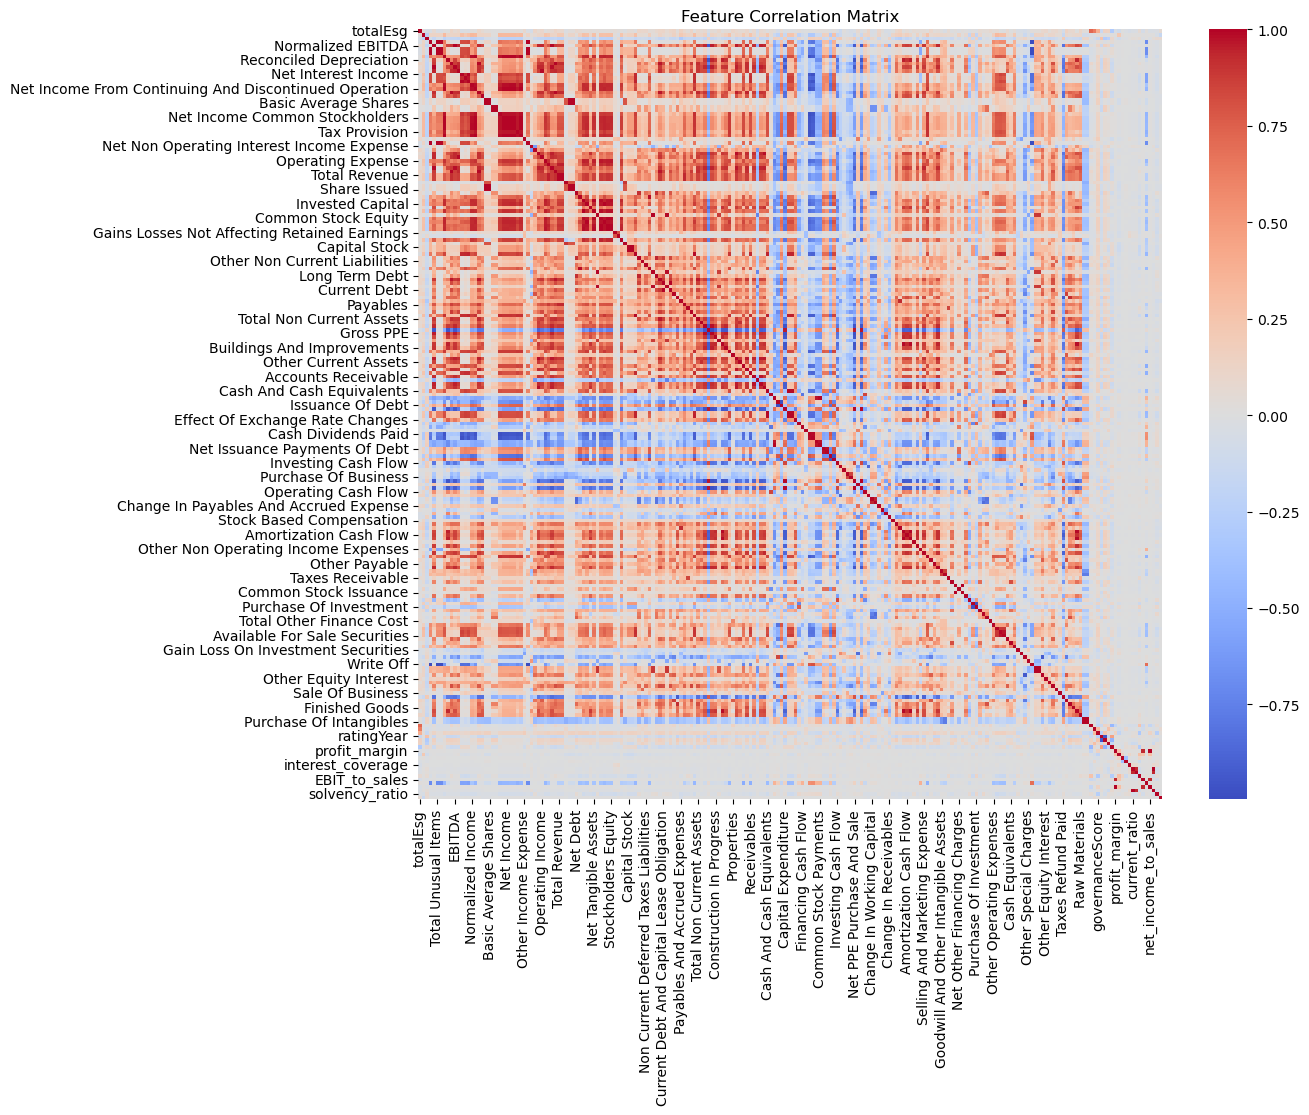

In [49]:
num_df = df_latest.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Convert to Distance Matrix 
corr_matrix = corr_matrix.fillna(0)
distance_matrix_full = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix_full.values, 0) # Ensure diagonal is zero
condensed_distance_matrix = squareform(distance_matrix_full, checks=False)

In [ ]:
# Perform Hierarchical Clustering 
Z = linkage(condensed_distance_matrix, method='average') # Using 'average' linkage: uses the average of the distances between all pairs of points, one from each of the two sets of items.

Performing hierarchical clustering ('average' linkage)...


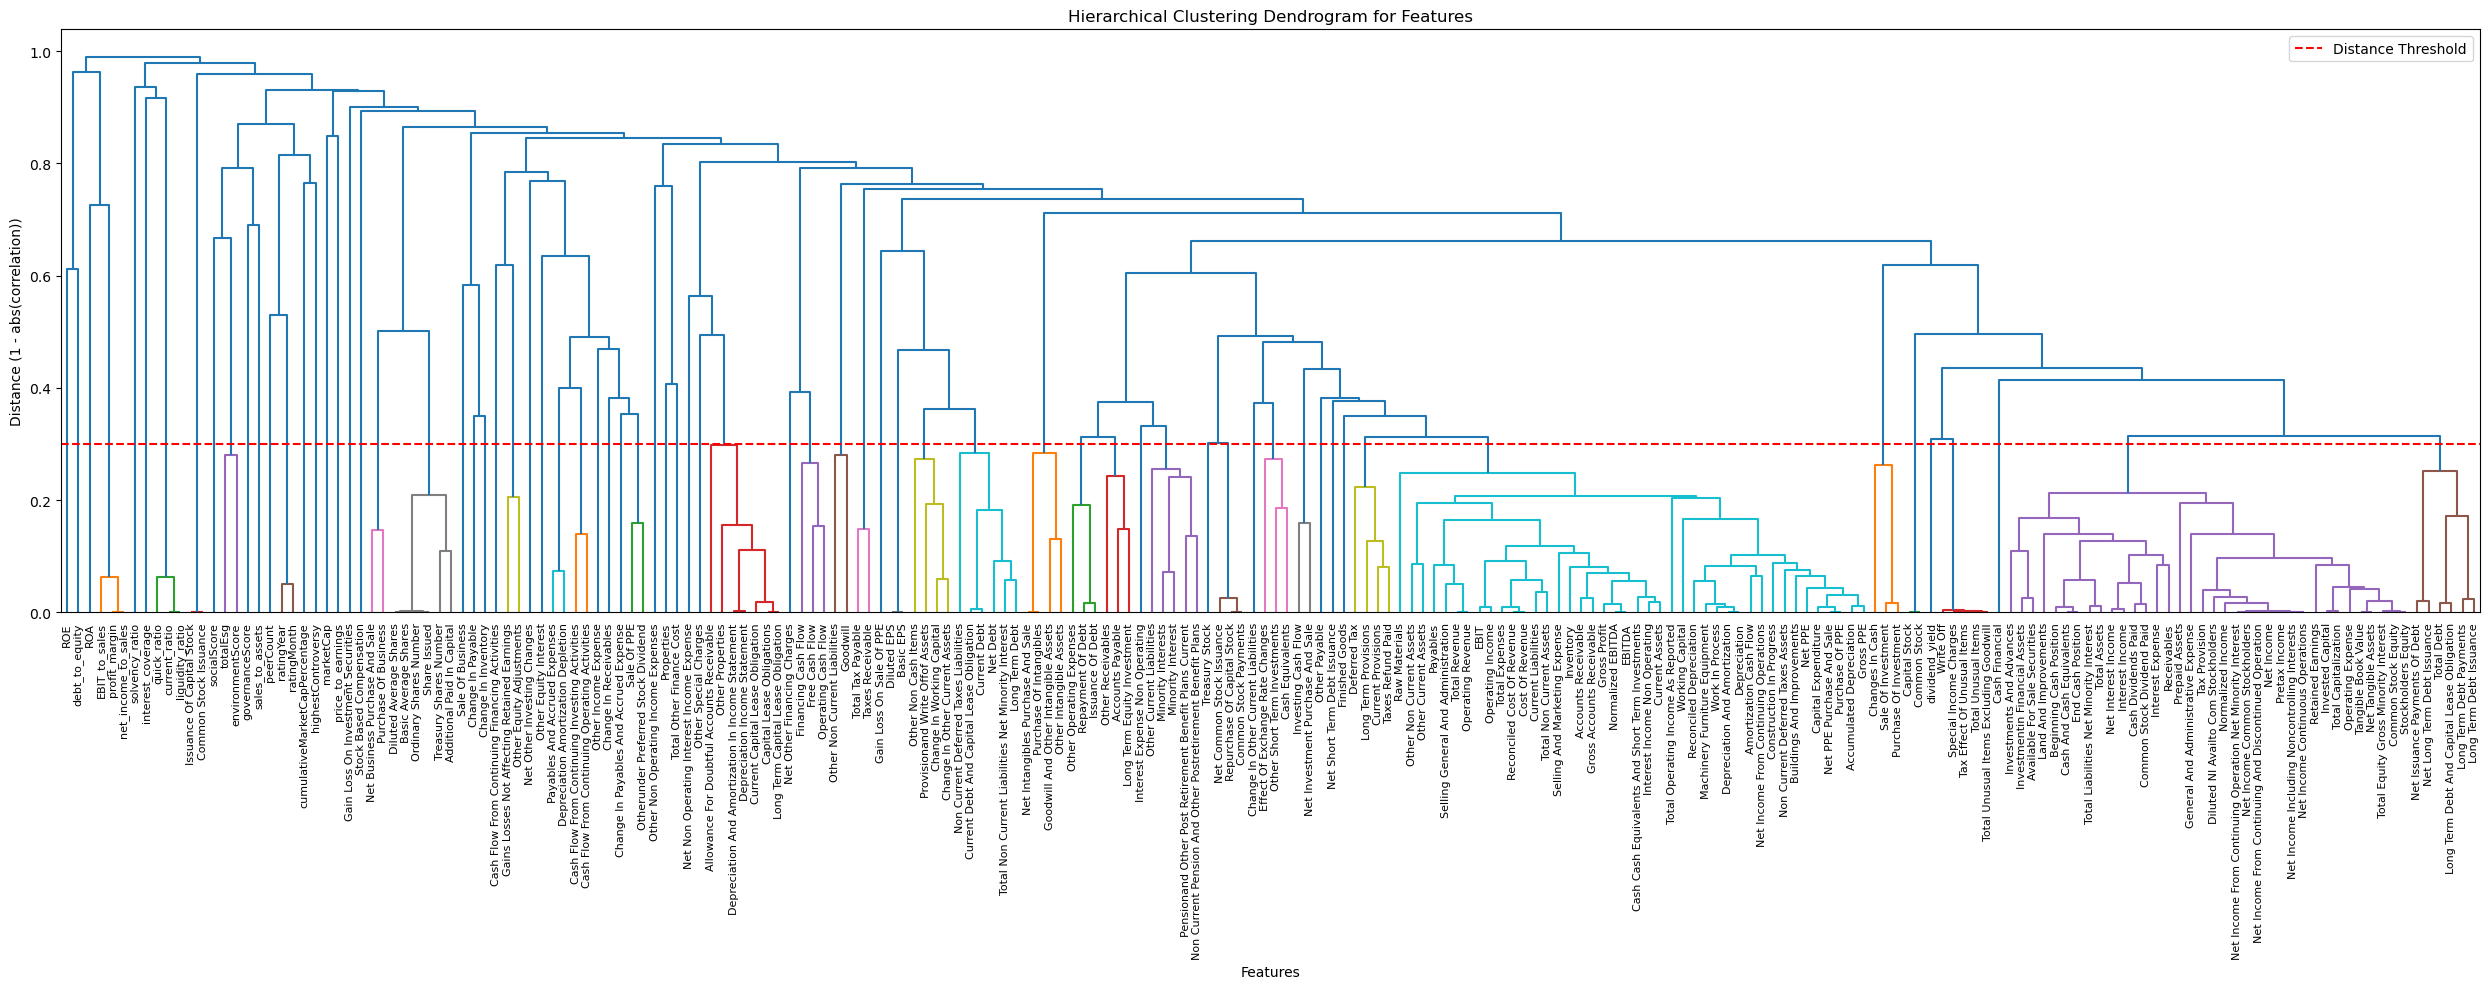

In [62]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram for Features')
plt.xlabel('Features')
plt.ylabel('Distance (1 - abs(correlation))')
dendrogram(
    Z,
    labels=corr_matrix.columns.tolist(),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=0.3 
    # truncate_mode='lastp', p=50 # show only the last 50 merged clusters
)
plt.axhline(y=0.3, color='r', linestyle='--', label='Distance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
# Form Flat Clusters 
distance_threshold = 0.3 # chosen based on dendrogram
print(f"\nForming flat clusters with distance threshold: {distance_threshold}")
clusters = fcluster(Z, distance_threshold, criterion='distance')


Forming flat clusters with distance threshold: 0.3


In [64]:
# Create a mapping from cluster ID to feature names
cluster_map = pd.DataFrame({'Feature': corr_matrix.columns, 'ClusterID': clusters})
print(f"Number of clusters found: {cluster_map['ClusterID'].nunique()}")

Number of clusters found: 71


In [ ]:
# Select Representative Features

# select the first feature encountered for each cluster
# representatives = cluster_map.drop_duplicates(subset=['ClusterID'], keep='first')['Feature'].tolist()



### Feature Scaling

### Categorical Encoding

In [ ]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])